# **IMPORTS**

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from numpy import arange
import seaborn as sns

import re
import spacy.cli
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score


from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from wordcloud import WordCloud

In [ ]:
spacy.cli.download('en_core_web_sm')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **LOADING** **IN** **DATA**

In [ ]:

train = pd.read_csv("/content/Train (1).csv")
test = pd.read_csv("/content/Test (1).csv")

In [ ]:
sample = pd.read_csv("/content/SampleSubmission.csv")

# VIEWING OUR DATA SET

In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  5177 non-null   object
 1   label     5177 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.0+ KB


In [ ]:
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
test.head()

,tweet_id,safe_text
0,00BHHHP1,user user amp CARDINAL vaccine give CARDINAL h...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,I 'm kinda every ep < user > `` ripped headlin...
3,01HOEQJW,How many innocent children die lack vaccinatio...
4,01JUKMAO,"CDC eyeing bird flu vaccine humans , though ri..."


# DATA CLEANINING

In [ ]:


def clean_text(df):
    i = 0
    for tweet in df['safe_text']:
      tweet = tweet.lower()
      tweet = re.sub(r'http\S+', 'LINK', tweet)
      tweet = re.sub(r'@\S+', 'USER_REF', tweet)
      tweet = re.sub(r'[^\w\s]', '', tweet)
      tweet = tweet.lstrip()
      tweet = tweet.rstrip()
      tweet = tweet.replace('  ', ' ')
      df.loc[i, 'safe_text'] = tweet
      i += 1

      return df

# STOP WORDS REMOVAL

In [ ]:


def remove_stopwords(df):
    my_stop_words = stopwords.words('english')
    my_stop_words.append('LINK')
    my_stop_words.append('USER_REF')

    df_index = 0

    for tweet in df['safe_text']:
      tweet = word_tokenize(tweet)
      tweet = [word for word in tweet if not word in my_stop_words]
      tweet = ' '.join(tweet)

      df.loc[df_index, 'safe_text'] = tweet
      df_index += 1

    return df

## ENTITIES FINDER

In [ ]:


def entities(df):
    df_index = 0

    for tweet in df['safe_text']:
      tweet = nlp(tweet)

      for entity in tweet.ents:
        df.loc[df_index, 'safe_text'] = df.loc[df_index, 'safe_text'].replace(str(entity.text), str(entity.label_))

      df_index += 1

      return df

## LEMMITAZATION OF TEXT DATA

In [ ]:


def lem_text(df):
    df_index = 0

    for tweet in df['safe_text']:
      tweet = nlp(tweet)
      
      for token in tweet:
        df.loc[df_index, 'safe_text'] = df.loc[df_index, 'safe_text'].replace(str(token.text), str(token.lemma_))

      df_index += 1

      return df

## clean, remove stop words, entities, and lemmatize train set

In [ ]:

clean_text(train)
remove_stopwords(train)
entities(train)
lem_text(train)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,amp big homie meanboy3000 meanboy mb mbs mmr s...,0.0,1.000000
1,E3303EME,I 'm 100 % thinking devoting career proving au...,1.0,1.000000
2,M4IVFSMS,"# whatcausesautism VACCINES , DO NOT VACCINATE...",-1.0,1.000000
3,1DR6ROZ4,I mean immunize kid something wo n't secretly ...,-1.0,1.000000
4,J77ENIIE,Thanks < user > Catch performing La Nuit NYC 1...,0.0,1.000000
...,...,...,...,...
9996,IU0TIJDI,Living time sperm I used waste Jenny McCarthy ...,1.0,1.000000
9997,WKKPCJY6,"< user > < user > In spite measles outbreaks ,...",1.0,0.666667
9998,ST3A265H,Interesting trends child immunization Oklahoma...,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000


## STR TYPE DATA

In [ ]:

test[['safe_text']] = test[['safe_text']].astype(str)

In [ ]:

clean_text(test)
remove_stopwords(test)
entities(test)
lem_text(test)

,tweet_id,safe_text
0,00BHHHP1,user user amp CARDINAL vaccine give CARDINAL h...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,I 'm kinda every ep < user > `` ripped headlin...
3,01HOEQJW,How many innocent children die lack vaccinatio...
4,01JUKMAO,"CDC eyeing bird flu vaccine humans , though ri..."
...,...,...
5172,ZXVVNC5O,jenny mccarthy new years rockin eve . done lat...
5173,ZYIANVI8,Measles reported Clark Co. 1st time since 2011...
5174,ZYITEHAH,< user > issues alert regarding Measles TX . K...
5175,ZZ3BMBTG,I ca n't believe people n't vaccinate kids ! I...


## CHECK THE MISSING VALUES

In [ ]:
train.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [ ]:
test.isnull().sum()

tweet_id     0
safe_text    0
dtype: int64

In [ ]:

train.dropna(thresh=3, inplace=True)

In [ ]:

train.label.value_counts()

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64

In [ ]:

train['label'].mask(train['label'] >= 0.5, 1, inplace=True)

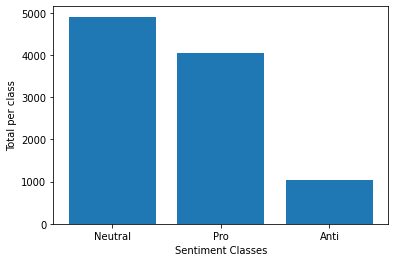

In [ ]:
counts = train["label"].value_counts()
plt.bar(range(len(counts)), counts)
plt.xticks([0, 1, 2], ['Neutral', 'Pro', 'Anti'])

plt.ylabel("Total per class")
plt.xlabel("Sentiment Classes")
plt.show()

In [ ]:

len(train[train.label==0])/len(train.label)

0.4908

In [ ]:

X_train = train['safe_text']
X_train

0        amp big homie meanboy3000 meanboy mb mbs mmr s...
1        I 'm 100 % thinking devoting career proving au...
2        # whatcausesautism VACCINES , DO NOT VACCINATE...
3        I mean immunize kid something wo n't secretly ...
4        Thanks < user > Catch performing La Nuit NYC 1...
                               ...                        
9996     Living time sperm I used waste Jenny McCarthy ...
9997     < user > < user > In spite measles outbreaks ,...
9998     Interesting trends child immunization Oklahoma...
9999     CDC Says Measles Are At Highest Levels In Deca...
10000    Pneumonia vaccine : women w risk pulmonary dis...
Name: safe_text, Length: 10000, dtype: object

In [ ]:
y_train = train['label']
y_train

0        0.0
1        1.0
2       -1.0
3       -1.0
4        0.0
        ... 
9996     1.0
9997     1.0
9998     0.0
9999     0.0
10000    1.0
Name: label, Length: 10000, dtype: float64

In [ ]:
X_test = test['safe_text']
X_test

0       user user amp CARDINAL vaccine give CARDINAL h...
1       Students starting school without whooping coug...
2       I 'm kinda every ep < user > `` ripped headlin...
3       How many innocent children die lack vaccinatio...
4       CDC eyeing bird flu vaccine humans , though ri...
                              ...                        
5172    jenny mccarthy new years rockin eve . done lat...
5173    Measles reported Clark Co. 1st time since 2011...
5174    < user > issues alert regarding Measles TX . K...
5175    I ca n't believe people n't vaccinate kids ! I...
5176    `` < user > Alternatives # Flu Vaccine < url >...
Name: safe_text, Length: 5177, dtype: object

In [ ]:
vectorizer = TfidfVectorizer(lowercase=True,
                            stop_words='english',
                            ngram_range=(1, 2))

X_train = vectorizer.fit_transform(X_train)

# fit on models

## linear SVC

In [ ]:
linear_svc = LinearSVC()

In [ ]:
linear_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
X_test = vectorizer.transform(X_test)

In [ ]:
y_pred_linearsvc = linear_svc.predict(X_test)

## create submition file

In [ ]:


submit_lsvc = test.copy()
submit_lsvc.drop(columns=['safe_text'], inplace=True)
submit_lsvc['label'] = y_pred_linearsvc

submit_lsvc['label'] = submit_lsvc['label'].astype(int)
submit_lsvc = submit_lsvc.set_index('tweet_id')

In [ ]:
submit_lsvc.head()

,label
tweet_id,
00BHHHP1,1
00UNMD0E,1
01AXPTJF,0
01HOEQJW,1
01JUKMAO,0


In [ ]:
submit_lsvc.to_csv('submit_lsvc.csv')